<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Convolutional Neural Network (CNN)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cuda:0].


### Dataset

In [ ]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw





Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Data Iterator

In [ ]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [ ]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    # conv layer의 channel dim과 mlp의 hidden dim을 
    # 정할 수 있도록 하는 것이 네트워크 튜닝에 편하다
    def __init__(self,name='cnn',xdim=[1,28,28],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(
                    # FILL IN HERE
                    in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1, 1),
                    padding=self.ksize//2  # input spatial dim과 output spatial dim 같도록
                )) # convlution 
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling, spatial dim 절반씩 줄어든다
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            # batch-norm, dropout - train과 test에서 다르게 동작해야 한다
            # 따라서 model.train(), model.eval() 설정해줘야 한다
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten())  # 한 줄로 폈을때 몇 개의 dim이 될지
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(
                # FILL IN HERE
                prev_hdim, hdim, bias=True
                               ))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)
            # add_module의 장점: 이름을 정할 수 있다
            # tf는 namescope가 있다 - 변수명 정할 수 있다
            # pytorch는 namescope가 없어서 변수명 정하는게 자유롭지 않다
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

# hdims=[256, 128]일 때 28x28 -> 14x14x32 -> 7x7x64 -> (flatten) -> 256 -> 128 -> 10
C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[32],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


### Check Parameters

In [ ]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

# 0: conv, 1, 2, 3: batch-norm, activation, max-polling, 4:conv, ...

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[-0.713  0.687  0.385 -0.462  0.952]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.077 -0.011  0.002 -0.017 -0.084]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.005  0.031  0.039 -0.007  0.015]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[-0.028  0.091 -0.106 -0.092 -0.272]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


### Simple Forward Path of the CNN Model

In [ ]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
# .detach().cpu().numpy()
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.544, 0.033, 0.822,  ..., 0.149, 0.013, 0.871],
          [0.137, 0.341, 0.897,  ..., 0.228, 0.209, 0.229],
          [0.453, 0.769, 0.104,  ..., 0.711, 0.639, 0.344],
          ...,
          [0.982, 0.103, 0.147,  ..., 0.414, 0.970, 0.320],
          [0.575, 0.281, 0.684,  ..., 0.870, 0.422, 0.146],
          [0.358, 0.122, 0.034,  ..., 0.249, 0.956, 0.125]]],


        [[[0.250, 0.727, 0.811,  ..., 0.721, 0.360, 0.608],
          [0.936, 0.184, 0.914,  ..., 0.662, 0.784, 0.671],
          [0.866, 0.232, 0.688,  ..., 0.015, 0.183, 0.664],
          ...,
          [0.514, 0.646, 0.626,  ..., 0.992, 0.672, 0.137],
          [0.186, 0.876, 0.065,  ..., 0.166, 0.933, 0.465],
          [0.915, 0.562, 0.068,  ..., 0.448, 0.111, 0.202]]]], device='cuda:0')
y_torch:
 tensor([[-1.700, -0.891, -0.372,  3.157, -1.995, -1.316, -5.234, -0.254, -1.618,
         -2.993],
        [-2.653, -0.074,  0.995,  2.321, -0.745,  2.742,  2.984,  0.153, -4.927,
         -0.757]], device=

### Evaluation Function

In [ ]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        #####################################################
        model.eval() # evaluate (affects DropOut and BN)
        #####################################################
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [ ]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.095] test_accr:[0.095].


### Train

In [ ]:
print ("Start training.")
C.init_param() # initialize parameters
###################################
C.train() # to train mode 
###################################
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

# 앞의 mlp 코드와 다를게 없다!
# 모델 안에서 mlp를 쓰는지 cnn을 쓰는지만 바뀌었고
# 같은 데이터셋, optimizer, loss function 활용한다

# train - test 성능 차이 별로 없다
# generalization performance 좋다 -> cnn이 image에 적합

Start training.
epoch:[0] loss:[0.575] train_accr:[0.955] test_accr:[0.958].
epoch:[1] loss:[0.178] train_accr:[0.972] test_accr:[0.974].
epoch:[2] loss:[0.124] train_accr:[0.981] test_accr:[0.981].
epoch:[3] loss:[0.104] train_accr:[0.984] test_accr:[0.985].
epoch:[4] loss:[0.092] train_accr:[0.986] test_accr:[0.984].
epoch:[5] loss:[0.083] train_accr:[0.988] test_accr:[0.985].
epoch:[6] loss:[0.076] train_accr:[0.989] test_accr:[0.988].
epoch:[7] loss:[0.069] train_accr:[0.990] test_accr:[0.988].
epoch:[8] loss:[0.064] train_accr:[0.990] test_accr:[0.988].
epoch:[9] loss:[0.063] train_accr:[0.991] test_accr:[0.989].
Done


### Test

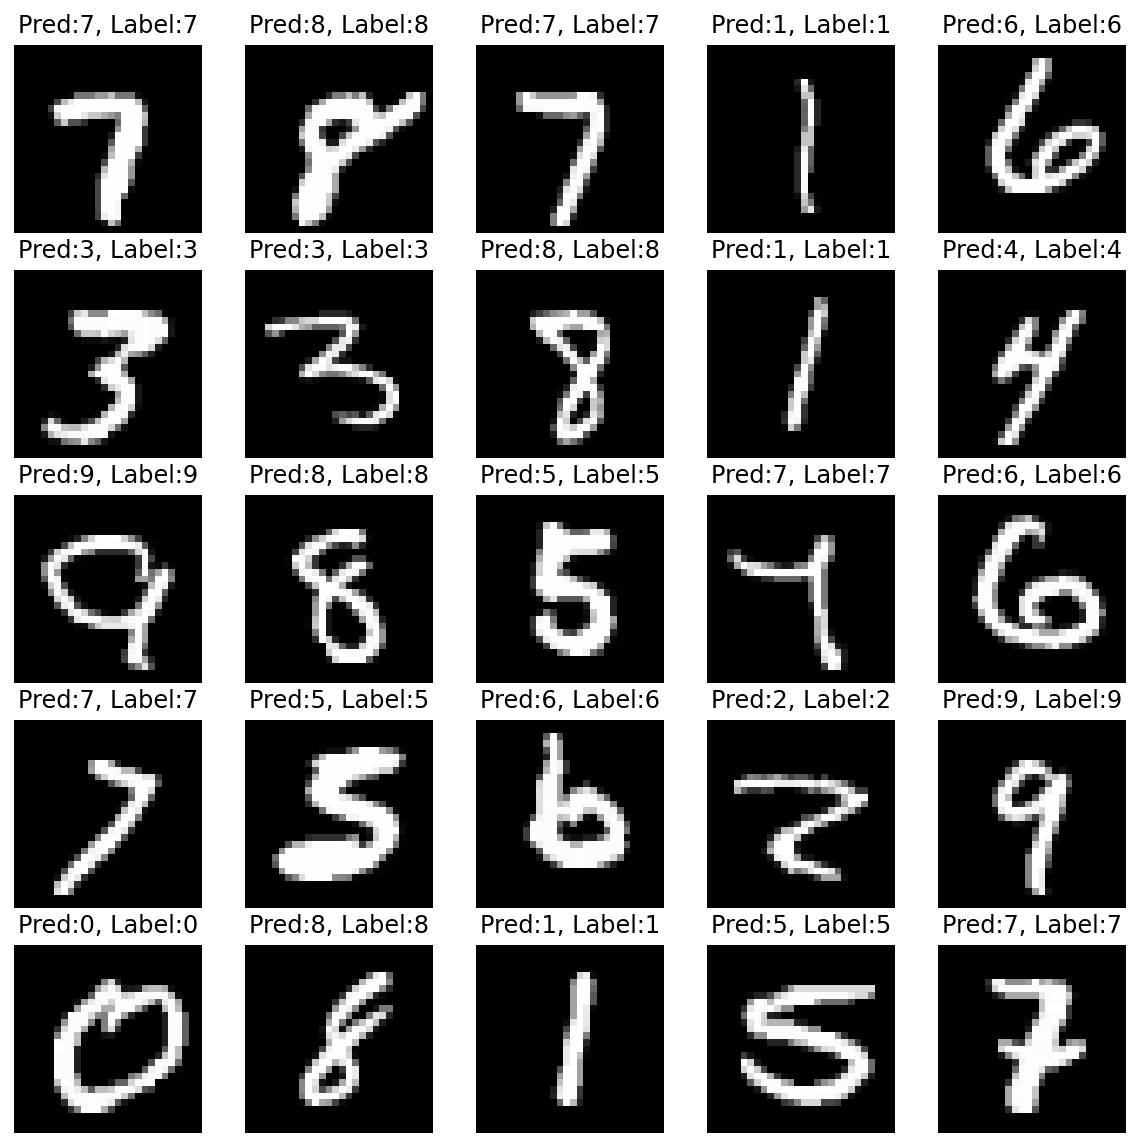

Done


In [ ]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")